# Markov Chain Monte Carlo

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as smf
import arviz as az
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

### Easy

##### 8E1

Which of the following is a requirement of the simple Metropolis algorithm?  

1. The parameter must be discrete.
1. The likelihood function must be Gaussian.
1. The proposal distribution must be symmetric.

**Answer:**
1. Not a requirement. The parameter can be continuous.
1. Not a requirement. Can be any continuous probability function
1. Is a requirement.

##### 8E2

Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra efficiency? Are there any limitations to the Gibbs sampling strategy?

**Answer:**  

Gibbs sampling uses *adaptive proposals*  in which the distribution of the proposed parameter values adjust itself depending upon the parameter values at the momemt. This is done by taking a combination of prior distributions and likelihoods known s *conjugate pairs*.

Limitations:  
- Some Conjugate priors may not have strong scientific basis.
- Also, Inefficient with large dimensions

##### 8E3

Which sort of parameters can Hamiltonian Monte Carlo not handle? Can you explain why?

**Answer:**  

Discrete parameters. HMC updates parameter values by calculating the gradient. This requires the parameter to be continuous.

##### 8E4

Explain the difference between effective number of samples, `n_eff` as calculated by Stan, and actual number of samples.

**Answer:**  

The number of samples available in the dataset are the "actual number of samples". However, there can be cases where one feature does not have much variation and is repeated multiple times. When this occurs, our models don't learn much from the samples are there are not many "new" cases to learn from. Hence, `n_eff` is an approximation of the number of effective samples used by the model to build parameter estimates.

##### 8E5

Which value should `Rhat` approach, when a chain is sampling the posterior distribution correctly?

**Answer:**  

`RHat` should approach 1.

##### 8E6

Sketch a good trace plot for a Markov chain, one that is effectively sampling the posterior distribution. What is good about its shape? Then sketch a trace plot for a malfunctioning Markov chain. What about its shape indicates malfunction?

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1982.18draws/s]


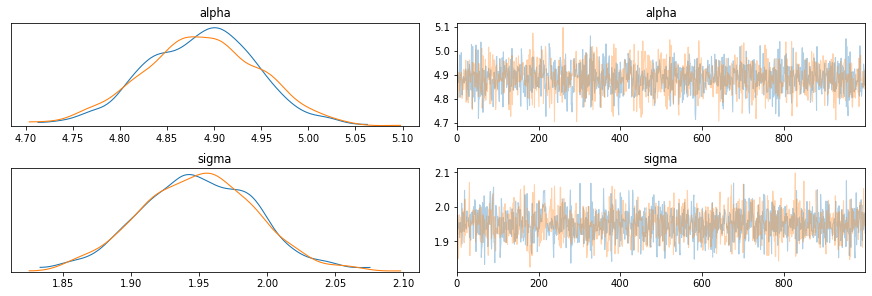

In [5]:
# Good traceplot
y = np.random.normal(5,2,1000)

with pm.Model() as m8_e6a:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    sigma = pm.Uniform("sigma", 0, 100)
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)
    trace_m8_e6a = pm.sample(1000, tune=1000)
    

az.plot_trace(trace_m8_e6a);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains, 369 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 513.11draws/s]
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4322141429000657, but should be close to 0.8. Try to increase the number of tuning steps.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


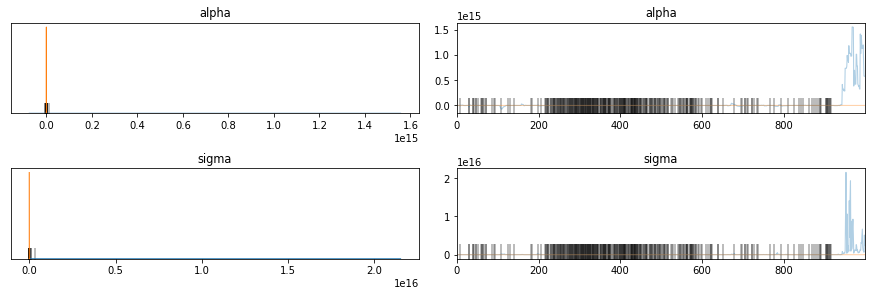

In [6]:
# Bad traceplot
y = np.array([-1., 1.])

with pm.Model() as m8_e6b:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)
    trace_m8_e6b = pm.sample(1000, tune=1000)
    

az.plot_trace(trace_m8_e6b);

### Medium

##### 8M1

Re-estimate the terrain ruggedness model from the chapter, but now using a uniform prior and an exponential prior for the standard deviation, `sigma`. The uniform prior should be `dunif(0, 10)` and the exponential should be `dexp(1)`. Do the different priors have any deductible influence on the posterior distribution?

In [7]:
d = pd.read_csv('../../data/rugged.csv', sep=';')
d['log_gdp'] = np.log(d.rgdppc_2000)
dd = d.loc[np.isfinite(d.rgdppc_2000),:]

In [9]:
# Uniform
with pm.Model() as m8_m1a:
    a = pm.Normal('a', mu=0, sd=100)
    bR = pm.Normal('bR', mu=0, sd=10)
    bA = pm.Normal('bA', mu=0, sd=10)
    bAR = pm.Normal('bAR', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa + bAR * dd.rugged * dd.cont_africa)
    sigma = pm.Uniform('sigma', 0, 10)
    log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd.log_gdp)
    trace_m8_m1a = pm.sample(1000, tune=1000)

# Exponential
with pm.Model() as m8_m1b:
    a = pm.Normal('a', mu=0, sd=100)
    bR = pm.Normal('bR', mu=0, sd=10)
    bA = pm.Normal('bA', mu=0, sd=10)
    bAR = pm.Normal('bAR', mu=0, sd=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa + bAR * dd.rugged * dd.cont_africa)
    sigma = pm.Exponential('sigma', 1)
    log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd.log_gdp)
    trace_m8_m1b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 908.35draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 893.02draws/s] 


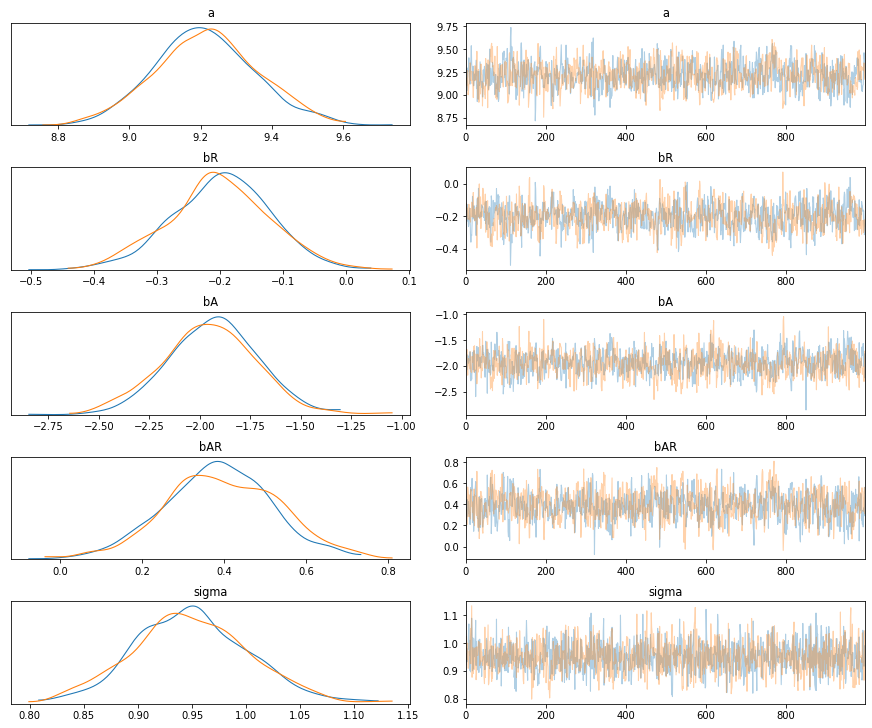

In [14]:
az.plot_trace(trace_m8_m1a, var_names=['~mu']);

In [11]:
pm.summary(trace_m8_m1a, var_names=['~mu'], kind='stats')

,mean,sd,hpd_3%,hpd_97%
a,9.215,0.142,8.946,9.484
bR,-0.200,0.079,-0.352,-0.051
bA,-1.941,0.226,-2.358,-1.518
bAR,0.391,0.133,0.162,0.665
sigma,0.950,0.054,0.843,1.047


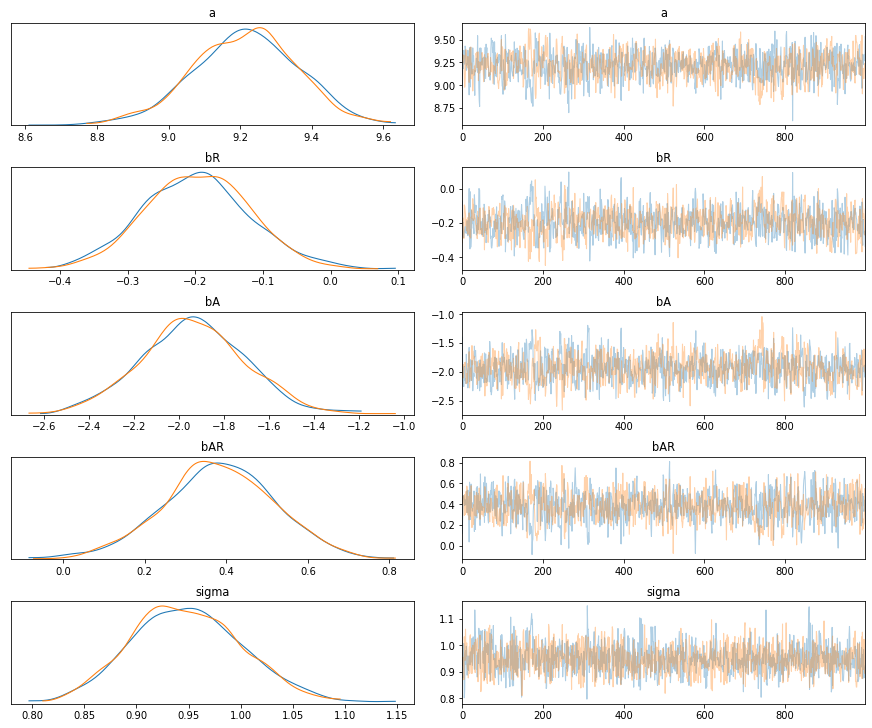

In [15]:
az.plot_trace(trace_m8_m1b, var_names=['~mu']);

In [13]:
pm.summary(trace_m8_m1b, var_names=['~mu'], kind='stats')

,mean,sd,hpd_3%,hpd_97%
a,9.215,0.146,8.967,9.518
bR,-0.197,0.080,-0.347,-0.049
bA,-1.934,0.233,-2.365,-1.489
bAR,0.383,0.135,0.118,0.627
sigma,0.949,0.054,0.852,1.052


##### 8M2

The Cauchy and exponential priors from the terrain ruggedness model are very weak. They can be made more informative by reducing their scale. Compare the `dcauchy` and `dexp` priors for progressively smaller values of the scaling parameter. As these priors become stronger, how does each influence the posterior distribution?

In [18]:
cauchy_traces = []
exp_traces = []

for i in range(1, 6):
    with pm.Model() as m8_m2a:
        a = pm.Normal('a', mu=0, sd=100)
        bR = pm.Normal('bR', mu=0, sd=10)
        bA = pm.Normal('bA', mu=0, sd=10)
        bAR = pm.Normal('bAR', mu=0, sd=10)
        mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa + bAR * dd.rugged * dd.cont_africa)
        sigma = pm.HalfCauchy('sigma', i)
        log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd.log_gdp)
        trace_m8_m2a = pm.sample(1000, tune=1000)
        cauchy_traces.append(trace_m8_m2a)
        
    with pm.Model() as m8_m2b:
        a = pm.Normal('a', mu=0, sd=100)
        bR = pm.Normal('bR', mu=0, sd=10)
        bA = pm.Normal('bA', mu=0, sd=10)
        bAR = pm.Normal('bAR', mu=0, sd=10)
        mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa + bAR * dd.rugged * dd.cont_africa)
        sigma = pm.Exponential('sigma', i)
        log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd.log_gdp)
        trace_m8_m2b = pm.sample(1000, tune=1000)
        exp_traces.append(trace_m8_m2b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 977.86draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 988.01draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1093.99draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 939.30draws/s] 
Auto-assigning NUTS sampler...
Initializ

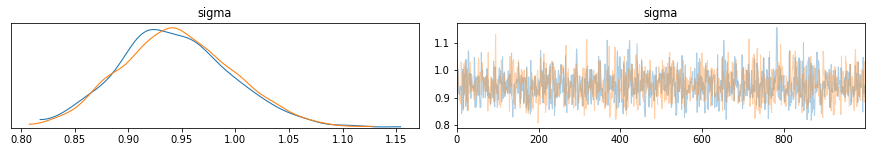

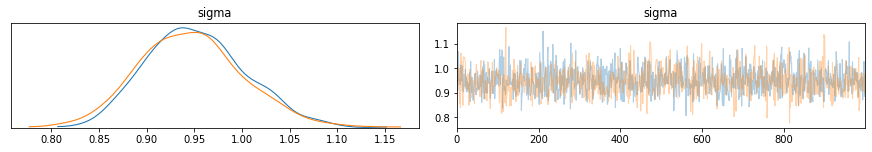

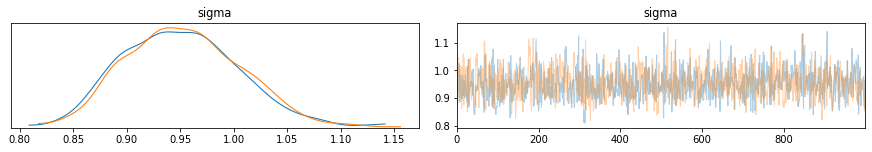

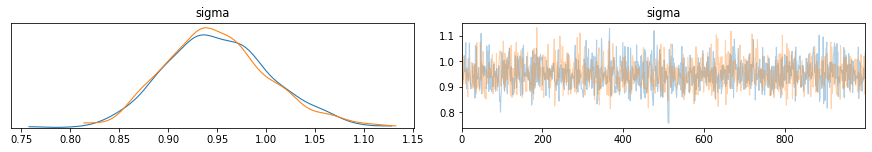

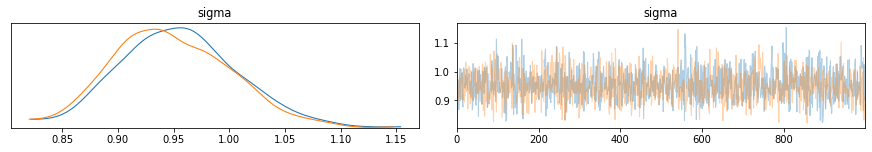

In [22]:
for i,trace in enumerate(cauchy_traces):
    az.plot_trace(trace, var_names=["sigma"])

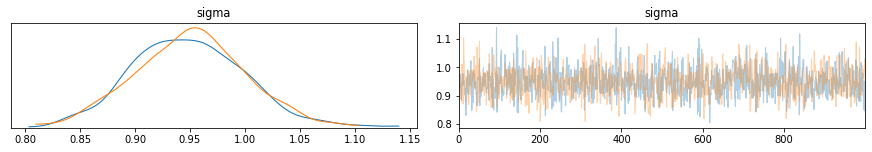

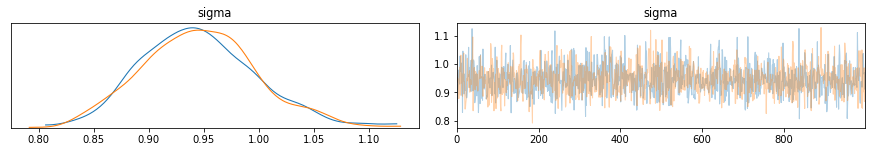

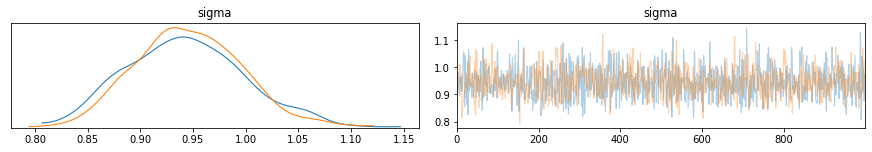

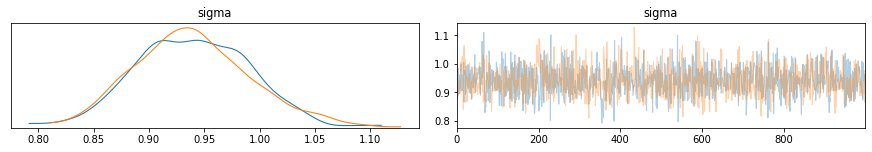

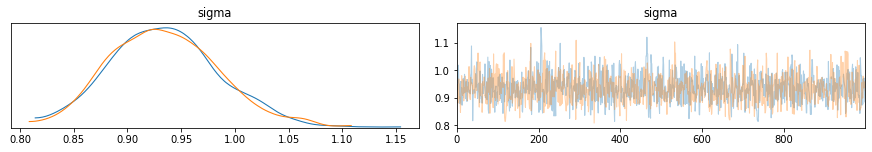

In [23]:
for trace in exp_traces:
    az.plot_trace(trace, var_names=["sigma"])

##### 8M3

Re-estimate one of the Stan models from the chapter, but at different numbers of warmup iterations. Be sure to use the same number of sampling iterations in each case. Compare the `n_eff` values. How much warmup is enough?

In [24]:
neff_traces = []
for i in range(1, 6):
    with pm.Model() as m8_m3:
        a = pm.Normal('a', mu=0, sd=100)
        bR = pm.Normal('bR', mu=0, sd=10)
        bA = pm.Normal('bA', mu=0, sd=10)
        bAR = pm.Normal('bAR', mu=0, sd=10)
        mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa + bAR * dd.rugged * dd.cont_africa)
        sigma = pm.Uniform('sigma', 0,100)
        log_gdp = pm.Normal('log_gdp', mu=mu, sd=sigma, observed=dd.log_gdp)
        trace_m8_m3 = pm.sample(1000, tune=i*500)
        neff_traces.append(trace_m8_m3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:03<00:00, 961.47draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 916.22draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:04<00:00, 1095.91draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [00:05<00:00, 1052.81draws/s]
Auto-assigning NUTS sampler...
Initializ

In [72]:
for i, trace in enumerate(neff_traces):
    n_eff = pm.stats.effective_n(trace, var_names=["~mu"])
    print(f"Warm-up of {(i+1)*500} gives Effective n of \n{n_eff}")
    print()

Warm-up of 500 gives Effective n of 
<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 779.9
    bR       float64 785.1
    bA       float64 976.8
    bAR      float64 1.06e+03
    sigma    float64 1.632e+03

Warm-up of 1000 gives Effective n of 
<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 671.7
    bR       float64 739.0
    bA       float64 742.5
    bAR      float64 761.4
    sigma    float64 1.269e+03

Warm-up of 1500 gives Effective n of 
<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 633.7
    bR       float64 686.5
    bA       float64 909.1
    bAR      float64 959.6
    sigma    float64 1.248e+03

Warm-up of 2000 gives Effective n of 
<xarray.Dataset>
Dimensions:  ()
Data variables:
    a        float64 877.7
    bR       float64 780.7
    bA       float64 953.9
    bAR      float64 968.7
    sigma    float64 1.516e+03

Warm-up of 2500 gives Effective n of 
<xarray.Dataset>
Dimensions:  ()
Data variables:
   

### Hard

##### 8H1

Run the model below and then inspect the posterior distribution and explain what it is accomplishing.  

```r
mp <- map2stan(
    alist(
        a ~ dnorm(0,1),
        b ~ dcauchy(0,1)
    ),
    data=list(y=1),
    start=list(a=0,b=0),
    iter=1e4, warmup=100, WAIC=FALSE )
```

Compare the samples for the parameters `a` and `b`. Can you explain the different trace plots, using what you know about the Cauchy distribution?

In [73]:
with pm.Model() as m8_h1:
    a = pm.Normal("a", mu=0, sd=1, testval=0)
    b = pm.Cauchy("b", alpha=0, beta=1, testval=0)
    trace_m8_h1 = pm.sample(1000, tune=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2200/2200 [00:02<00:00, 930.13draws/s] 
The acceptance probability does not match the target. It is 0.16961993522361923, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


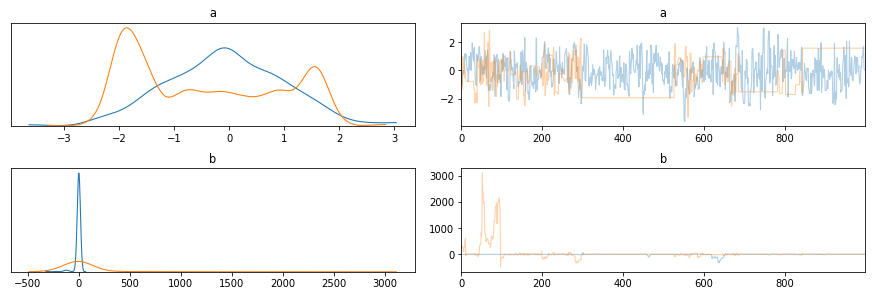

In [75]:
az.plot_trace(trace_m8_h1);

##### 8H2

Recall the divorce rate example from Chapter 5. Repeat that analysis, using `map2stan` this time, fitting models `m5.1`, `m5.2` and `m5.3`. Use `compare` to compare the models on the basis of WAIC. Explain the results.

In [77]:
## We simply refit the same model.
# load data
d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')
d = (
    d
    .assign(Marriage_s = lambda x: (x.Marriage - x.Marriage.mean()) / x.Marriage.std(),
            MedianAgeMarriage_s = lambda x: (x.MedianAgeMarriage - x.MedianAgeMarriage.mean()) / x.MedianAgeMarriage.std()
           )
)

# m5.1
with pm.Model() as m8_h2_1:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.MedianAgeMarriage_s)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_m8_h2_1 = pm.sample(1000, tune=1000)
    
with pm.Model() as m8_h2_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.Marriage_s)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_m8_h2_2 = pm.sample(1000, tune=1000)
    
with pm.Model() as m8_h2_3:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    bA = pm.Normal('bA', mu=0, sd=1, shape=2)
    alpha = pm.Normal('alpha', mu=10, sd=10)
    mu = pm.Deterministic('mu', alpha + bA[0] * d.Marriage_s + bA[1] * d.MedianAgeMarriage_s)
    divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_m8_h2_3 = pm.sample(1000, tune=1000)
    
compare_df = az.compare({f"m5_{i}": eval(f"trace_m8_h2_{i}") for i in [1,2,3]})
compare_df

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1301.51draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1564.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, bA, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1003.22draws/s]


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5_1,0,186.721,4.13411,0,0.59839,11.999,0,True,deviance
m5_3,1,187.864,4.89179,1.1431,0.337779,9.15633,0.991041,True,deviance
m5_2,2,200.241,3.34266,13.5198,0.0638317,11.8886,9.32023,True,deviance


##### 8H3

Sometimes changing the prior for one parameter has unanticipated effects on the other parameters. This is because when a parameter is highly correlated with another parameter in the posterior, the prior influences both parameters. Here's an example to work and think through.  

Go back to the leg length example in CHapter 5. Here is the code again, which simulates height and leg lengths for 100 imagined individuals:  

```r
N <- 100
height <- rnorm(N, 10, 2)
leg_prop <- runif(N, 0.4, 0.5)
leg_left <- leg_prop * height + rnorm(N, 0, 0.02)
leg_left <- leg_prop * height + rnorm(N, 0, 0.02)
d <- data.frame(height, left_leg, leg_right)
```

And below is the model you fit before, resulting in a highly correlated posterior for the two beta parameters. This time, fir the model using `map2stan`:  

```r
m5.8s <- map2stan(
    alist(
        height ~ dnorm( mu, sigma)
        mu ~ a + bl*leg_left + br*leg_right
        a ~ dnorm(10, 100),
        bl ~ dnorm( 2, 10 ),
        br ~ dnorm( 2, 10 ),
        sigma ~ dcauchy( 0, 1)
    ),
    data=d, chains=4,
    start=list(a=10, bl=0, br=0, sigma=1) )
```

Compare the posterior distribution produced by the code above to the posterior distribution produced when you change the prior for `br` so that it is strictly positive:  

```r
m5.8s1 <- map2stan(
    alist(
        height ~ dnorm( mu, sigma)
        mu ~ a + bl*leg_left + br*leg_right
        a ~ dnorm(10, 100),
        bl ~ dnorm( 2, 10 ),
        br ~ dnorm( 2, 10 ) & T[0,],
        sigma ~ dcauchy( 0, 1)
    ),
    data=d, chains=4,
    start=list(a=10, bl=0, br=0, sigma=1) )
```

Note that `T[0,]` on the right-hand side of the prior for `br`. What the `T[0,]` does is *truncate* tthe normal distributionso that it has positive probability only above zero. In other words, that prior ensures that the posterior distribution for `br` will have no probability mass below zero.  

Compare the two posterior distributions for `m5.8s` and `m5.8s2`. What has changed in the posterior distribution of both beta parameters? Can you explain the change induced by the change in the prior?

In [82]:
# Simulate data
N = 100
height = np.random.normal(10, 2, N)
leg_prop = np.random.uniform(0.4, 0.5, N)
leg_left = leg_prop * height + np.random.normal(0, 0.02, N)
leg_right = leg_prop * height + np.random.normal(0, 0.02, N)
d = pd.DataFrame([height, leg_prop, leg_left, leg_right], index=['height', 'leg_prop', 'leg_left', 'leg_right']).T

In [84]:
# Unbounded br
with pm.Model() as m5_8s:
    sigma = pm.Uniform('sigma', 0, 10)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    a = pm.Normal('a', mu=10, sd=100)
    mu = pm.Deterministic('mu', a + bl*d.leg_left + br*d.leg_right)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_5_8s = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, br, bl, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [03:05<00:00, 21.54draws/s]


In [85]:
# Bounded br  
with pm.Model() as m5_8s1:
    sigma = pm.Uniform('sigma', 0, 10)
    bl = pm.Normal('bl', mu=2, sd=10)
    BoundNormal = pm.Bound(pm.Normal, lower=0.0)
    br = BoundNormal('br', mu=2, sd=10)
    a = pm.Normal('a', mu=10, sd=100)
    mu = pm.Deterministic('mu', a + bl*d.leg_left + br*d.leg_right)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_5_8s1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, br, bl, sigma]
Sampling 2 chains, 407 divergences: 100%|██████████| 4000/4000 [01:31<00:00, 43.84draws/s] 
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 334 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.11136074038026678, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [86]:
pm.stats.summary(trace_5_8s, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
bl,1.150,1.934,-1.793,4.282
br,0.866,1.942,-2.230,3.862
a,0.977,0.293,0.526,1.450
sigma,0.628,0.045,0.553,0.695


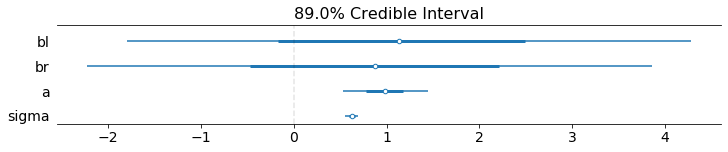

In [87]:
pm.forestplot(trace_5_8s, varnames=['~mu'], credible_interval=0.89, combined=True, figsize=(10,2))
plt.axvline(color='k', alpha=0.1, linestyle='--');

In [88]:
pm.stats.summary(trace_5_8s1, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
bl,0.332,0.727,-0.376,1.491
a,0.711,0.311,0.414,1.188
sigma,0.606,0.041,0.569,0.676
br,1.740,0.771,0.543,2.494


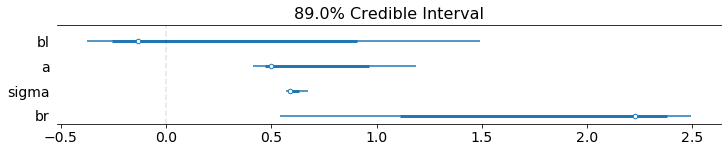

In [89]:
pm.forestplot(trace_5_8s1, varnames=['~mu'], credible_interval=0.89, combined=True, figsize=(10,2))
plt.axvline(color='k', alpha=0.1, linestyle='--');

##### 8H4

For the two models fit in the previous problem, use DIC or WAIC to compare the effective numbers of parameters for each model. Which model has more effective parameters? Why?

In [91]:
m_dict = {"m5_8s": trace_5_8s, "m5_8s1": trace_5_8s1}
az.compare(m_dict)

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m5_8s1,0,192.324,2.76594,0,0.569421,12.5046,0,False,deviance
m5_8s,1,192.898,3.55941,0.573997,0.430579,12.6234,1.86124,False,deviance


In [206]:
def calculate_dic(trace):
    n_samples = 1000
    n_cases = d.shape[0]
    ll = np.zeros((n_cases, n_samples))

    for i in range(n_samples):
        mu = trace["a"][i+1000] + trace["bl"][i+1000] * d.leg_left + trace["br"][i+1000]*d.leg_right
        ll[:,i] = stats.norm.logpdf(d['height'], loc=mu, scale=trace['sigma'][i+1000])

    deviance = -2 * ll.sum(1)

    D_bar = deviance.mean()
    D_hat = np.sum(trace["a"].mean() + trace["bl"].mean() * d.leg_left + trace["br"].mean()*d.leg_right)
    dic = D_bar + (D_bar - D_hat)
    return dic

dic_8s = calculate_dic(trace_5_8s)
dic_8s1 = calculate_dic(trace_5_8s1)

In [207]:
dic_8s

2786.359629007229

In [208]:
dic_8s1

2820.221460454387

##### 8H5

Modify the Metropolis algorithm code from the chapter to handle the case that the island populations have different distribution than the island labels. This means the island's number will not be the same as its population.

In [112]:
num_weeks = 100000
positions = np.zeros(num_weeks)
current = 10

# Proportions different for each island
proportions = np.random.rand(10)
proportions = proportions / proportions.sum()

for i in range(num_weeks):
    # record current position
    positions[i] = current
    
    # flip coin to generate proposal
    proposal = current + np.random.choice([-1,1])
    # make sure he loops around the archipelago
    proposal = np.where(proposal < 1, 10, proposal)
    proposal = np.where(proposal > 10, 1, proposal)

    # move?
    # update based on different proportions
    prob_move = proportions[proposal - 1] / proportions[current - 1]
    current = proposal if np.random.rand() < prob_move else current

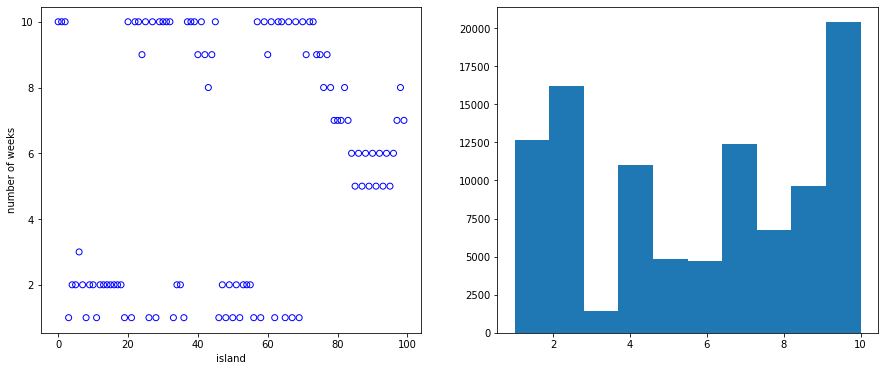

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.scatter(range(100), positions[:100], facecolors='none', edgecolors='b')
ax1.set_ylabel('island')
ax1.set_xlabel('week')

ax2.hist(positions, align='mid')
ax1.set_ylabel('number of weeks')
ax1.set_xlabel('island');

In [117]:
# Calculate proportions from simulation
counts = np.unique(positions, return_counts=True)[1]
sim_proportions = counts / counts.sum()

# Check that simulated proportions are close to real proportions
proportions - sim_proportions

array([ 0.00171357,  0.0027492 , -0.00083953, -0.00428842, -0.0018258 ,
       -0.00137734,  0.00032099,  0.00083554,  0.00116456,  0.00154723])

##### 8H6

Modify the Metropolis algorithm code from the chapter to write your own simple MCMC estimator for globe tossing data and model from Chapter 2.

In [128]:
num_tosses = 10000
positions = np.zeros(num_tosses)
current = 1 # currently on land

# Proportions of water and land
proportions = np.array([0.7, 0.3])

for i in range(num_weeks):
    # record current position
    positions[i] = current
    
    # flip coin to generate proposal
    proposal = np.random.choice([0,1])

    # move to land or water
    prob_move = proportions[proposal] / proportions[current]
    current = proposal if np.random.rand() < prob_move else current

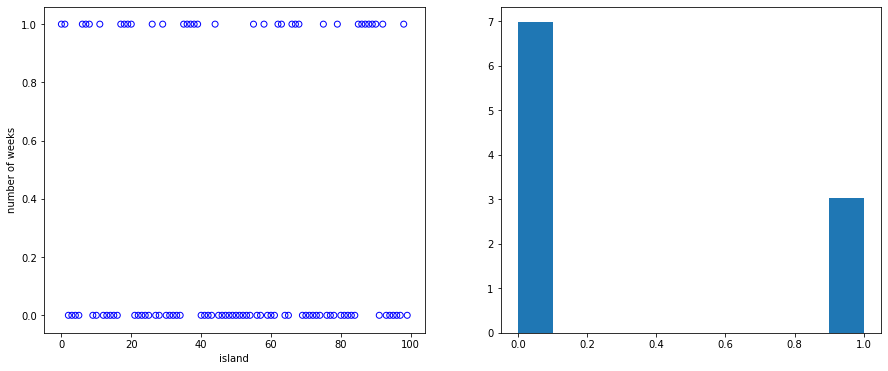

In [133]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.scatter(range(100), positions[:100], facecolors='none', edgecolors='b')
ax1.set_ylabel('island')
ax1.set_xlabel('week')

ax2.hist(positions, align='mid', density=True)
ax1.set_ylabel('number of weeks')
ax1.set_xlabel('island');

In [134]:
# Calculate proportions from simulation
counts = np.unique(positions, return_counts=True)[1]
sim_proportions = counts / counts.sum()

# Check that simulated proportions are close to real proportions
proportions - sim_proportions

array([ 0.002, -0.002])

In [ ]:
pm.